# American Option Pricing for KO using Crank–Nicolson + PSOR

An option is a contract that allows the buyer to either sell or purchase an asset on or before a specified date for a specified price. The particulars depend on the type of contract, with the most common being puts (sell) and call (buy) options for stocks. 

Several means of pricing these options exist, each with their own advantages. The Black-Scholes formula, formally introduced in 1973 by Fischer Black and Myron Scholes, is the most popular and frequently used because of it's simplicity and practicallity. However, this same simplicity makes the model limited in it's capacity, as it is explicitly constructed to handle European options with a fixed exercise date and no dividend payouts. Consequently, since it's inception, a plethora of variants have been created to handle various types of contracts and computational issues which arise when pricing.

The focus here will be American options which have both early exercise opportunities and dividend payouts. With the choice to exercise the contracts early, the option pricing problem becomes an optimisation problem. Specifically, it becomes a Linear Complementarity Problem (LCP) with the goal of maximising the price of the contract.

I will start by converting the Black-Scholes formula into a partial differential equation (PDE) as this enables us to use numerical methods and handle any payoff structure, unlike the closed form which only uses European options. From there, an early exercise contraint is added to ensure the price of the contract is always greater than the payoff. The asset price - strike price grid will then be discretised so that the Crank-Nicolson may be used. The most common solver for the LCP resulting from Crank-Nicolson finite difference discretization of the American option Black-Scholes equation is the Projected Successive Over-Relaxation method.


It is important to mention that though the Black-Scholes was constructed for option pricing, it is most frequently used to evaluate market sentiment through the implied volatilty. However, that is beyond the scope of this work, as I will exclusively be looking at estimating the price of American options.

# 1. Black–Scholes Formula

The variables used in the formula:

- **$S$** – Current price of the underlying asset  
- **$K$** – Strike price of the option  
- **$T$** – Time to maturity (in years)  
- **$r$** – Continuously compounded risk-free interest rate  
- **$\sigma$** – Volatility of the underlying asset’s returns  
- **$\Phi(\cdot)$** – Standard normal cumulative distribution function  
- **$d_1, d_2$** – Intermediate quantities defined as:

$$
d_1 = \frac{\ln(S/K) + (r + \tfrac{1}{2}\sigma^2)T}{\sigma\sqrt{T}},
\qquad
d_2 = d_1 - \sigma\sqrt{T}.
$$


For a **call option** with strike price $K$, maturity $T$, and no dividends ($q = 0$), the price at time 0 is given by:

$$
C_{\text{BS}}(S, K, T, r, \sigma) 
\;=\;
S \cdot \Phi(d_1) 
\;-\;
K \, e^{-\,r\,T} \,\Phi(d_2),
$$



For a **put option** the price at time 0 is given by:

$$
P_{\text{BS}}(S, K, T, r, \sigma) 
\;=\;
K \, e^{-\,r\,T} \,\Phi(d_2)
\;-\;
S \cdot \Phi(d_1),
$$




---


## 1.1 The Black–Scholes PDE

$$
\frac{\partial V}{\partial t}
+ \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}
+ r S \frac{\partial V}{\partial S}
- r V = 0,
$$

**Parameters**
- \(S\): underlying asset price  
- \(t\): time  
- $\sigma$: volatility  
- \(r\): risk-free interest rate
- $V(S,t)$ : option price 


**Use for:**
- American options due to early exercise
- Require full price surface
- Complex Boundary
- Numerical stability

---
## Crank-Nicolson

- When solving PDE version of Black-Scholes, common approaches include:
    - Finite Difference Methods
        - Trade off between speed and stability for Explicit and Implicit respectively
        - CN balances both, but requires solving a linear system at each step, and can create oscillations near payoff discontinuities
    - Finite Element Methods
        - Very complex implementation
        - Highly flexible domain discretisation, but requires meshing and integration routines.
    - Binomial Trees
        - Easiest numerical method to code
        - converges to BS, but very slowly
    - Fourier Methods
        - Extremely fast and very accurate for smooth payoffs, but very unintuitive and difficult to implement and boundary conditions require care.
        - Extends naturally to diffusion models
        
- Finite difference method for numerically solving heat equations and time-dependent PDE
- More robust -> small mistakes won't be as impactful
- Based on the trapezoidal rule
    - numerical method to solve ode.
    - implicit second order method


- Core Idea:
    - Averages explicit (Forward Euler) and implicit (backward Euler) schemes
    
- Steps:
    - Define the PDE
    - Add an inquality constraint for optimal exercise
    - Add the no arbitrage complementarity 
        - This makes it a Linear Complementarity Problem instead of a plain PDE
        - "Standard"/most common solver for CN LCP is the PSOR
    - Discretise price grid with S and T
    - Terminal Payoff at maturity: 
    - Boundary Conditions
    
    

---
## Projected Successive Over-Relaxation


---
## Why

Pros:
- More accurate than closed form approximations (Bjerksund–Stensland)
- Gives prices for all strikes at once because PDE produces a full grid
    - Useful for implied volatility sheet


Cons:
- Slower than Bjerksund–Stensland
- More complex implementation than trees
- More memory to store entire price grid


## To do list:

1. Download stock & option data
2. Build difference solver
3. Include Discrete Dividend adjustment
4. Price Puts & Call Options
5. Compare to Market prices
6. Visualise

# Step 1 - Data Retrieval

### Imports

In [29]:
import numpy as np
import pandas as pd
import datetime
import yfinance as yf
import time
import matplotlib.pyplot as plt

### Configuration

In [2]:
# Configuration (you can change these if you like)
TICKER = "KO"                 # Underlying ticker
EXPIRY_INDEX_FOR_RANGE = 2    # Which expiry to use for strike range
RISK_FREE_RATE = 0.0425       # 4.25% annual risk-free rate
M_SPATIAL = 100               # Number of stock grid steps
N_TIME = 100                  # Number of time steps
OMEGA = 1.5                   # PSOR relaxation parameter
TOL = 1e-6                    # PSOR convergence tolerance
MAX_ITER = 500                # Max PSOR iterations per time step


### Download KO market data

1. Create a `yfinance.Ticker` object for KO.
2. Get the current stock price `S_fixed`.


In [3]:
# Create a Ticker object for KO
ticker_symbol = "KO"
ticker = yf.Ticker(ticker_symbol)

# Current asset price
S_fixed = ticker.info["regularMarketPrice"]
print(f"Current {TICKER} stock price: {S_fixed:.4f}")


Current KO stock price: 72.6100


### Options Data

1. Get the list of option expiration dates.
2. Choose one expiration (using index `EXPIRY_INDEX_FOR_RANGE`)
3. Compute time to expiration in years.
4. Download the option chain (calls and puts) for that expiration.

In [4]:
# List of available option expirations

expirations = ticker.options

if not expirations:
    raise RuntimeError("No options data available for this ticker.")

(f"Contract Expiration Dates: {expirations[:5]}")

"Contract Expiration Dates: ('2025-11-28', '2025-12-05', '2025-12-12', '2025-12-19', '2025-12-26')"

In [5]:
# Choose an expiration by index

expiration = expirations[EXPIRY_INDEX_FOR_RANGE]
today = datetime.datetime.today()

print(f"Using expiration date: {expiration}")
print(f"Today: {today.strftime('%Y-%m-%d')}")

Using expiration date: 2025-12-12
Today: 2025-11-26


In [6]:
# Time to maturity in years
exp_date = datetime.datetime.strptime(expiration, "%Y-%m-%d")
T = (exp_date - today).days / 365.0
print(f"Time to expiration (years): {T:.4f}")

Time to expiration (years): 0.0411


In [7]:
# Option chain (calls and puts)
option_chain = ticker.option_chain(expiration)
calls = option_chain.calls
puts = option_chain.puts

# Strike prices (from calls, sorted)
K_range = np.sort(calls["strike"].values)
print(f"Number of strikes: {len(K_range)}")

calls.head()

Number of strikes: 19


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,KO251212C00050000,2025-11-12 19:24:28+00:00,50.0,21.87,0.0,0.0,0.00,0.000000,NaN,0,0.00001,True,REGULAR,USD
1,KO251212C00064000,2025-11-25 15:45:42+00:00,64.0,8.59,0.0,0.0,0.79,10.128205,1.0,0,0.00001,True,REGULAR,USD
2,KO251212C00065000,2025-11-07 19:57:45+00:00,65.0,5.50,0.0,0.0,0.00,0.000000,1.0,0,0.00001,True,REGULAR,USD
3,KO251212C00066000,2025-11-18 15:55:54+00:00,66.0,5.10,0.0,0.0,0.00,0.000000,1.0,0,0.00001,True,REGULAR,USD
4,KO251212C00067000,2025-11-14 19:58:25+00:00,67.0,4.17,0.0,0.0,0.00,0.000000,2.0,0,0.00001,True,REGULAR,USD


### Estimate volatility and extract dividend information


1. Estimate a single volatility value `sigma` as the **average** of the call implied volatilities.
2. Get the dividend rate and next ex-dividend date from `ticker.info`.
3. Convert the next ex-dividend date into a time in years.
4. Store a list of discrete dividends in the format:
   \[
   [( \text{dividend\_amount}, \text{time\_in\_years} )]
   \]
If no dividend info is available, we use an empty list.


In [8]:
# Volatility estimate: mean of call implied vols
sigma_estimates = calls["impliedVolatility"].values
sigma = float(np.mean(sigma_estimates))
print(f"Estimated volatility (mean call IV): {sigma:.4f}")


Estimated volatility (mean call IV): 0.0366


In [9]:
# Dividend info
dividend_rate = ticker.info.get("dividendRate", 0.0)
ex_dividend_timestamp = ticker.info.get("exDividendDate", None)

if dividend_rate and ex_dividend_timestamp:
    
    ex_div_date = datetime.datetime.fromtimestamp(ex_dividend_timestamp)
    time_until_dividend = (ex_div_date - today).days / 365.0
    dividends = [(dividend_rate, time_until_dividend)]
    
    print(f"Using discrete dividend: {dividend_rate} at t = {time_until_dividend:.4f} years")

else:
    dividends = []
    print("No discrete dividend info used.")

print(f"Risk-free rate: {RISK_FREE_RATE}")

Using discrete dividend: 2.04 at t = 0.0110 years
Risk-free rate: 0.0425


# Step 2 -  Finite Difference Solver

### Functions:

- `build_stock_grid`
    - Build a stock price grid from 0 to `Smax = 2 * S0`


In [10]:
def build_stock_grid(S0, M):
    
    Smax = 2.0 * S0
    stock_grid = np.linspace(0.0, Smax, M + 1)
    dS = Smax / M
    return stock_grid, Smax, dS



- `initialize_option_matrix`
    - Create a `(M+1) x (N+1)` matrix for option values `V(S_i, t_j)`


In [11]:
def initialize_option_matrix(M, N):

    return np.zeros((M + 1, N + 1))


- `set_boundary_conditions`
    - Applies terminal payoff (at maturity) and boundary conditions at `S=0` and `S=Smax`.

        - V : option value matrix
        - stock_grid : S values
        - K : strike
        - T : time to maturity (years)
        - r : risk-free rate
        - Smax : max stock price in grid
        - N : number of time steps
        - option_type : "call" or "put"


In [12]:
def set_boundary_conditions(V, stock_grid, K, T, r, Smax, N, option_type):

    # Terminal payoff at t = T
    if option_type == "call":
        V[:, -1] = np.maximum(stock_grid - K, 0.0)
    else:
        V[:, -1] = np.maximum(K - stock_grid, 0.0)

    # Time grid for boundary conditions
    time_points = np.linspace(0.0, T, N + 1)

    # Boundaries in S
    if option_type == "call":
        # S = 0: call is worthless
        V[0, :] = 0.0
        # S = Smax: approximate deep ITM call value
        V[-1, :] = Smax - K * np.exp(-r * (T - time_points))
    else:
        # S = 0: deep ITM put
        V[0, :] = K * np.exp(-r * (T - time_points))
        # S = Smax: put ~ 0
        V[-1, :] = 0.0


- `construct_crank_nicolson_matrices`
    - Builds the tridiagonal matrices `A` and `B` for the Crank–Nicolson scheme.
    
        - M     : number of spatial steps
        - dt    : time step size
        - r     : risk-free rate
        - sigma : volatility

    - Returns:
         - A, B : (M-1) x (M-1)
         - alpha, beta, gamma : coefficient arrays

In [13]:
def construct_crank_nicolson_matrices(M, dt, r, sigma):
    
    i_vals = np.arange(1, M)  # interior indices

    alpha = 0.25 * dt * (sigma**2 * i_vals**2 - r * i_vals)
    beta  = -0.5 * dt * (sigma**2 * i_vals**2 + r)
    gamma = 0.25 * dt * (sigma**2 * i_vals**2 + r * i_vals)

    diag_main_A = 1.0 - beta
    diag_main_B = 1.0 + beta

    diag_lower_A = alpha[1:]     # sub-diagonal for A
    diag_upper_A = gamma[:-1]    # super-diagonal for A

    diag_lower_B = -alpha[1:]    # sub-diagonal for B
    diag_upper_B = -gamma[:-1]   # super-diagonal for B

    A = np.diag(diag_main_A) \
        + np.diag(diag_lower_A, k=-1) \
        + np.diag(diag_upper_A, k=1)

    B = np.diag(diag_main_B) \
        + np.diag(diag_lower_B, k=-1) \
        + np.diag(diag_upper_B, k=1)

    return A, B, alpha, beta, gamma

- `psor_update`
    - Performs one PSOR sweep for `A x = b` while enforcing the American constraint `V >= intrinsic`.


In [14]:
def psor_update(A, b, x, stock_grid, K, option_type, omega):

    M_inner = len(x)  # equals M-1 (number of interior nodes)

    for i in range(1, M_inner - 1):
        old_xi = x[i]

        # SOR update
        x[i] = (1.0 - omega) * old_xi + (omega / A[i, i]) * (
            b[i] - A[i, :].dot(x) + A[i, i] * old_xi
        )

        # American constraint: V >= intrinsic
        if option_type == "call":
            intrinsic = max(stock_grid[i] - K, 0.0)
        else:
            intrinsic = max(K - stock_grid[i], 0.0)

        x[i] = max(x[i], intrinsic)

    return x

# Step 3 - Discrete Dividend Adjustment

- `adjust_for_dividend(...)`  
    - Models a discrete dividend by shifting the stock grid:  $\( S \to \max(S - D, 0) \)$ and interpolating the option values.

    - Apply a discrete dividend at time step j by shifting S -> S - D.
        - V : option value matrix
        - j : time index (integer)
        - stock_grid : array of stock prices
        - dividend_amount: dividend size


In [15]:
def adjust_for_dividend(V, j, stock_grid, dividend_amount):
    
    S_shifted = np.maximum(stock_grid - dividend_amount, 0.0)
    V[:, j] = np.interp(S_shifted, stock_grid, V[:, j])


- `solve_for_one_strike(...)`  
    - Full American option solver for a single strike:
        - Builds grid and matrices.
        - Steps backward in time with Crank–Nicolson.
        - Uses PSOR at each time step.
        - Applies `adjust_for_dividend` at the correct time steps.
        - Returns \( V(S_0, t=0) \).

    - Parameters:
        - S0         : current stock price
        - K          : strike
        - T          : time to maturity (years)
        - r          : risk-free rate
        - sigma      : volatility
        - dividends  : list of (amount, time) tuples
        - M, N       : grid sizes
        - option_type: "call" or "put"
        - omega      : PSOR relaxation parameter
        - tol        : PSOR convergence tolerance
        - max_iter   : max PSOR iterations per time step


In [16]:
def solve_for_one_strike(S0, K, T, r, sigma, dividends,
                         M, N, option_type, omega, tol, max_iter):

    stock_grid, Smax, dS = build_stock_grid(S0, M)
    dt = T / N

    # Option value matrix and boundary conditions
    V = initialize_option_matrix(M, N)
    set_boundary_conditions(V, stock_grid, K, T, r, Smax, N, option_type)

    # Crank–Nicolson matrices
    A, B, alpha, beta, gamma = construct_crank_nicolson_matrices(M, dt, r, sigma)

    # Map dividend times to discrete time indices
    dividend_steps = {}
    for (amount, t_div) in dividends:
        j_div = int(round(N * (t_div / T)))
        if 0 <= j_div <= N:
            dividend_steps[j_div] = amount

    # Backward time-stepping
    for j in range(N - 1, -1, -1):
        # Interior nodes
        rhs = B @ V[1:M, j + 1]
        x = V[1:M, j].copy()

        # PSOR iterations
        for _ in range(max_iter):
            x_old = x.copy()
            x = psor_update(A, rhs, x, stock_grid, K, option_type, omega)
            if np.linalg.norm(x - x_old, np.inf) < tol:
                break

        # Save updated interior values
        V[1:M, j] = x

        # Apply dividend if it occurs at time step j
        if j in dividend_steps:
            adjust_for_dividend(V, j, stock_grid, dividend_steps[j])

    # Interpolate price at S0 at t=0
    price = np.interp(S0, stock_grid, V[:, 0])
    return max(price, 0.0)

- `price_strike_range(...)`  
    - Uses `solve_for_one_strike` to price a vector of strikes.
    - Price an American option for each strike in K_array.

In [17]:
def price_strike_range(S0, K_array, T, r, sigma, dividends,
                       M=100, N=100, option_type="call",
                       omega=1.5, tol=1e-6, max_iter=500):

    prices = []
    for K in K_array:
        p = solve_for_one_strike(S0, K, T, r, sigma, dividends,
                                 M, N, option_type, omega, tol, max_iter)
        prices.append(p)
    return np.array(prices)

# Step 4 – Price American calls and puts across strikes and compare to market prices


1. Use `price_strike_range(...)` to compute (and time):
   - `call_prices` for all strikes in `K_range`.
   - `put_prices` for all strikes in `K_range`.

2. Build a DataFrame with model prices.

3. Extract market **last prices** for calls and puts from the option chain.

4. Merge model and market DataFrames on `Strike`.

5. Compute the Mean Squared Error (MSE) between model and market prices
   for calls and puts separately.

In [30]:
# Time the pricing of calls and puts across all strikes
print("Pricing American calls and puts across strikes...")
start_time = time.perf_counter()

call_prices = price_strike_range(
    S0=S_fixed,
    K_array=K_range,
    T=T,
    r=RISK_FREE_RATE,
    sigma=sigma,
    dividends=dividends,
    M=M_SPATIAL,
    N=N_TIME,
    option_type="call",
    omega=OMEGA,
    tol=TOL,
    max_iter=MAX_ITER,
)

put_prices = price_strike_range(
    S0=S_fixed,
    K_array=K_range,
    T=T,
    r=RISK_FREE_RATE,
    sigma=sigma,
    dividends=dividends,
    M=M_SPATIAL,
    N=N_TIME,
    option_type="put",
    omega=OMEGA,
    tol=TOL,
    max_iter=MAX_ITER,
)

elapsed_time = time.perf_counter() - start_time
print("Done pricing.")

print(f"Pricing time for all strikes (calls + puts): {elapsed_time:.2f} seconds")


Pricing American calls and puts across strikes...
Done pricing.
Pricing time for all strikes (calls + puts): 16.13 seconds


In [23]:
# PSOR results DataFrame

df_psor = pd.DataFrame({
    "Strike": K_range,
    "Call_PSOR": call_prices,
    "Put_PSOR": put_prices,
})

df_psor.head()

,Strike,Call_PSOR,Put_PSOR
0,50.0,21.1578,0.0
1,64.0,7.1578,0.0
2,65.0,6.1578,0.0
3,66.0,5.1578,0.0
4,67.0,4.1578,0.0


In [24]:
# Market last prices

df_calls = calls[["strike", "lastPrice"]].rename(columns={
    "strike": "Strike",
    "lastPrice": "Call_LastPrice"
})
df_puts = puts[["strike", "lastPrice"]].rename(columns={
    "strike": "Strike",
    "lastPrice": "Put_LastPrice"
})

df_chain = pd.merge(df_calls, df_puts, on="Strike", how="outer")

df_chain.head()

,Strike,Call_LastPrice,Put_LastPrice
0,50.0,21.87,0.06
1,58.0,NaN,0.03
2,59.0,NaN,0.08
3,60.0,NaN,0.08
4,61.0,NaN,0.06


In [26]:
# Merge model and market DataFrames on 'Strike'

df_final = pd.merge(df_psor, df_chain, on="Strike", how="outer")

df_final.head()

,Strike,Call_PSOR,Put_PSOR,Call_LastPrice,Put_LastPrice
0,50.0,21.1578,0.0,21.87,0.06
1,58.0,NaN,NaN,NaN,0.03
2,59.0,NaN,NaN,NaN,0.08
3,60.0,NaN,NaN,NaN,0.08
4,61.0,NaN,NaN,NaN,0.06


In [27]:
# MSE for calls
calls_clean = df_final.dropna(subset=["Call_PSOR", "Call_LastPrice"])
call_mse = np.mean((calls_clean["Call_PSOR"] - calls_clean["Call_LastPrice"])**2)

# MSE for puts
puts_clean = df_final.dropna(subset=["Put_PSOR", "Put_LastPrice"])
put_mse = np.mean((puts_clean["Put_PSOR"] - puts_clean["Put_LastPrice"])**2)

print("Mean Squared Error vs last prices:")
print(f"  Calls: {call_mse:.6f}")
print(f"  Puts : {put_mse:.6f}")

df_final.head()


Mean Squared Error vs last prices:
  Calls: 0.491333
  Puts : 1.444723


,Strike,Call_PSOR,Put_PSOR,Call_LastPrice,Put_LastPrice
0,50.0,21.1578,0.0,21.87,0.06
1,58.0,NaN,NaN,NaN,0.03
2,59.0,NaN,NaN,NaN,0.08
3,60.0,NaN,NaN,NaN,0.08
4,61.0,NaN,NaN,NaN,0.06


# Step 5 – Visualize model prices, market prices, and volume

Create three plots:

1. **Model prices vs strike**  
   - American call and put prices (from the PDE model).

2. **Market last prices vs strike**  
   - Call and put last prices from the option chain.

3. **Volume vs strike**  
   - Call and put trading volume by strike.



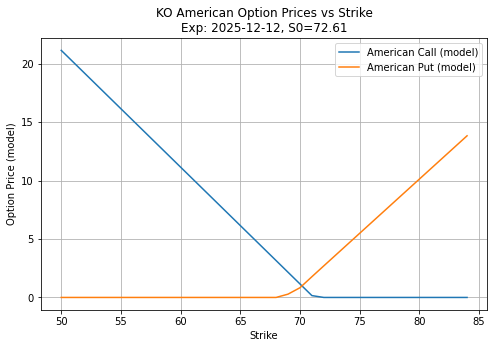

In [31]:
# Model prices vs strike
plt.figure(figsize=(8, 5))
plt.plot(K_range, call_prices, label="American Call (model)")
plt.plot(K_range, put_prices, label="American Put (model)")
plt.xlabel("Strike")
plt.ylabel("Option Price (model)")
plt.title(f"{TICKER} American Option Prices vs Strike\nExp: {expiration}, S0={S_fixed:.2f}")
plt.legend()
plt.grid(True)
plt.show()

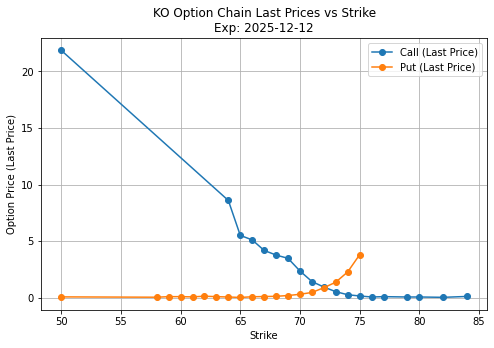

In [32]:
# Market last prices vs strike
plt.figure(figsize=(8, 5))
plt.plot(calls["strike"], calls["lastPrice"], marker="o", linestyle="-", label="Call (Last Price)")
plt.plot(puts["strike"], puts["lastPrice"], marker="o", linestyle="-", label="Put (Last Price)")
plt.xlabel("Strike")
plt.ylabel("Option Price (Last Price)")
plt.title(f"{TICKER} Option Chain Last Prices vs Strike\nExp: {expiration}")
plt.legend()
plt.grid(True)
plt.show()

# Sources

- Black Scholes PDE: https://www.quantstart.com/articles/Deriving-the-Black-Scholes-Equation/

- Black Scholes with early exercise constraint: https://www.linkedin.com/pulse/optimal-early-exercise-boundary-american-options-free-prateek-yadav-brctc/

- Crank Nicolson Method for Black-Scholes: https://antonismolski.medium.com/crank-nicholson-with-black-scholes-with-code-a27c0df17555

- "Algorithms of Finite Difference for Pricing American Options under Fractional Diffusion Models"
    - Jun Xi
    - Yanqing Chen
    - Jianwen Cao
    
- Paul Johnson, University of Manchester MATH60082

- "An Adaptive Successive Over-Relaxation Method for Computing the Black-Scholes Implied Volatility" 
    - Minqiang Li (Bloomberg LP)
    - Kyuseok Lee (College of Business, Korea Advanced Institute of Science and Technology (KAIST))
    - November 5, 2007